In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pymc as pm
from scipy.misc import comb

In [2]:
np.random.seed(42)

## Data import and cleaning

In [3]:
study_char = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Study Characteristics", 
                           index_col='RefID', na_values=['-', 'NR'])
outcomes = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Outcomes", 
                           na_values=['ND', 'NR'])
demographics = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Pt Demographics", na_values=['-', 'NR'])

Data cleaning

In [4]:
# Cast outcomes variables to floats
for col in ('Last FU Mean', 'Last FU SD',):
    outcomes[col] = outcomes[col].astype(float)

In [5]:
# Recode age category
study_char['age_cat'] = study_char.AgeCat.replace({'PRE-K':1, 'SCHOOL':0, 'TEEN':2})

In [6]:
# Fix data label typo
outcomes['Measure Instrument'] = outcomes['Measure Instrument'].replace({'Eyberg Child Behaviour Inventory, problem Subscale': 
                                        'Eyberg Child Behaviour Inventory, Problem Subscale'})
outcomes.Units = outcomes.Units.replace({'scale': 'Scale'})

In [7]:
# Parse followup times and convert to months
split_fut = outcomes.loc[outcomes['Last FU Time'].notnull(), 'Last FU Time'].apply(lambda x: str(x).split(' ')[:2])
fut_months = [float(time)/52.*(unit=='weeks') or float(time) for time, unit in split_fut]
outcomes.loc[outcomes['Last FU Time'].notnull(), 'Last FU Time'] = fut_months

We are assumung all CBC Externalizing values over 50 are T-scores, and those under 50 are raw scores. This recodes those observations.

In [8]:
cbce_ind = outcomes['Measure Instrument'].apply(lambda x: x.startswith('Child Behavior Checklist, Externalizing'))
under_50 = outcomes['BL Mean']<50
outcomes.loc[cbce_ind & (under_50^True), 'Measure Instrument'] = 'Child Behavior Checklist, Externalizing (T Score)'
outcomes.loc[cbce_ind & under_50, 'Measure Instrument'] = 'Child Behavior Checklist, Externalizing'

Recode measure instrument variables

In [9]:
instrument = []
subtype = []
units = []

for i,row in outcomes.iterrows():
    separator = row['Measure Instrument'].find(',')
    if separator == -1:
        separator = row['Measure Instrument'].find('-')
    instrument.append(row['Measure Instrument'][:separator])
    s = row['Measure Instrument'][separator+2:]
    paren = s.find('(')
    if paren > -1:
        subtype.append(s[:paren-1])
        units.append(s[paren+1:-1])
    else:
        subtype.append(s)
        if s.endswith('scale'):
            units.append('Scale')
        else:
            units.append('Score')
            
new_cols = pd.DataFrame({'instrument': instrument, 'subtype': subtype, 
                         'units': units}, index=outcomes.index)

In [10]:
outcomes['Measure Instrument'].value_counts()

Eyberg Child Behaviour Inventory, Intensity Subscale            63
Eyberg Child Behaviour Inventory, Problem Subscale              45
Child Behavior Checklist, Externalizing (T Score)               33
Child Behavior Checklist, Externalizing                         11
Eyberg Child Behaviour Inventory, Intensity Subscale (T Score)    10
Strengths and Difficulties Questionnaire- Conduct Problems Scale    10
Eyberg Child Behaviour Inventory, Problem Subscale (T Score)     4
Child Behavior Checklist, Aggression                             4
Strengths and Difficulties Questionnaire- Emotional Symptoms Scale     4
Strengths and Difficulties Questionnaire- Total Difficulties Score     4
Strengths and Difficulties Questionnaire- Total Score            4
Child Behavior Checklist, Conduct Problems                       2
Child Behavior Checklist, Rulebreaking                           2
Child Behavior Checklist, Conduct Problems (T Score)             2
Strengths and Difficulties Questionnaire- Im

In [11]:
new_cols.head()

,instrument,subtype,units
0,Eyberg Child Behaviour Inventory,Intensity Subscale,T Score
1,Eyberg Child Behaviour Inventory,Problem Subscale,T Score
2,Eyberg Child Behaviour Inventory,Intensity Subscale,T Score
3,Eyberg Child Behaviour Inventory,Problem Subscale,T Score
4,Child Behavior Checklist,Externalizing,Score


In [12]:
# Append new columns
outcomes = outcomes.join(new_cols)

In [13]:
outcomes.intvn.value_counts()

wlc              41
tau              37
iypt             26
pcit             16
pppsd             7
iyptndiyct        6
mst               5
it                4
pppo              4
ppcp              4
spokes            3
pcitc             3
snap              3
pppe              3
pmtndp            3
pmto              3
iyct              2
pmtpa             2
hncte             2
pcitabb           2
pmtnds            2
modularndn        2
hncstd            2
pmtsd             2
setpc             2
iyptadv           1
pstnds            1
hnc               1
cbt               1
modularndcomm     1
itpt              1
sst               1
kitkashrut        1
scip              1
mcfi              1
hitkashrut        1
projndsupport     1
pppstd            1
cpp               1
coaching          1
modularndclin     1
dtype: int64

## Data summaries

Cross-tabulation of the outcome counts by measure instrument

In [14]:
pd.crosstab(outcomes['instrument'], outcomes['Outcome'])

Outcome,"01 Behavior, disruptive","02 Behavior, aggression","06 Behavior, fighting, destruction, violation","08 Behavior, other"
instrument,,,,
Child Behavior Checklist,48,4,2,0
Eyberg Child Behaviour Inventory,122,0,0,0
Strengths and Difficulties Questionnaire,10,0,0,16


Distribution of age categories

In [15]:
study_char.AgeCat.value_counts()

SCHOOL    46
PRE-K     26
TEEN      14
dtype: int64

Frequencies of various intervention types

In [16]:
study_char['Intervention Type'].value_counts()

PHARM                                                           20
IY-PT                                                            8
MST                                                              7
PCIT                                                             5
IY-PT + IY-CT                                                    4
PMTO                                                             3
BSFT                                                             3
Triple P (enhanced)                                              3
PCIT-ABB                                                         2
OTH: Intensive treatment                                         2
IY-PT (nurse led)                                                2
CBT                                                              2
Fast Track                                                       2
PT                                                               2
IY-CT                                                         

## Extract variables of interest and merge tables

In [17]:
KQ1 = study_char[study_char.KQ=='KQ1']

In [18]:
study_varnames = ['Year', 'age_cat', 'Geographic setting', 'Age mean (years) ', 'Age SD (years)', 
              'Age min (years)', 'Age max (years)', 'Proportion Male (%)']

study_vars = KQ1[study_varnames].rename(columns={'Geographic setting': 'country', 
                           'Age mean (years) ': 'age_mean', 
                           'Age SD (years)': 'age_sd', 
                           'Age min (years)': 'age_min', 
                           'Age max (years)': 'age_max', 
                           'Proportion Male (%)': 'p_male'})

In [19]:
study_vars.head()

,Year,age_cat,country,age_mean,age_sd,age_min,age_max,p_male
RefID,,,,,,,,
23,2013,1,USA,2.80,0.61,2,4,62
100,2013,2,USA,14.60,1.30,11,18,83
103,2013,1,USA,5.67,1.72,3,8,53
141,2013,0,USA,9.90,1.30,8,11,73
156,2013,2,Netherlands,16.00,1.31,12,18,73


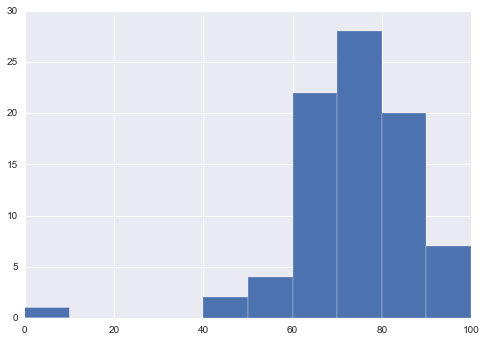

In [20]:
study_vars.p_male.hist()

Proportion missing

In [21]:
study_vars.isnull().mean(0).round(2)

Year        0.00
age_cat     0.00
country     0.00
age_mean    0.13
age_sd      0.20
age_min     0.07
age_max     0.08
p_male      0.01
dtype: float64

Will assume the mean age for those which are missing is simply the midpoint between minimum and maximum values

In [22]:
est_means = study_vars.apply(lambda x: x.age_min + (x.age_max - x.age_min) / 2, axis=1)[study_vars.age_mean.isnull()]
study_vars.loc[study_vars.age_mean.isnull(), 'age_mean'] = est_means

study_vars.age_mean.isnull().sum()

3

In [23]:
outcomes_varnames = ['Ref ID', 'Measure Instrument', 'instrument', 'subtype', 'units', 
                     'intvn', 'cc', 'pc', 'fc',
                     'BL N', 'BL Mean', 'BL SD', 
                     'EOT \nN', 'EOT Mean', 'EOT \nSD', 'Last FU Time', 'Last FU N', 
                     'Last FU Mean', 'Last FU SD', 'CS Group N', 'CS Mean', 'CS SD']

In [24]:
outcomes_vars = outcomes[outcomes_varnames].rename(columns={'Ref ID': 'RefID', 
                                                                       'Measure Instrument': 'measure_instrument',
                                                                       'cc': 'child_component',
                                                                       'pc': 'parent_component',
                                                                       'fc': 'family_component',
                                                                       'oc': 'other_component',
                                                                       'BL N': 'baseline_n',
                                                                       'BL Mean': 'baseline_mean',
                                                                       'BL SD': 'baseline_sd', 
                                                                       'EOT \nN': 'end_treat_n', 
                                                                       'EOT Mean': 'end_treat_mean', 
                                                                       'EOT \nSD': 'end_treat_sd', 
                                                                       'Last FU Time': 'followup_time', 
                                                                       'Last FU N': 'followup_n',
                                                                       'Last FU Mean': 'followup_mean', 
                                                                       'Last FU SD': 'followup_sd', 
                                                                       'CS Group N': 'change_n',
                                                                       'CS Mean': 'change_mean',
                                                                       'CS SD': 'change_sd'})

Recode intervention clasification

In [25]:
control = ((outcomes_vars.child_component^True) & 
           (outcomes_vars.parent_component^True) & 
           (outcomes_vars.family_component^True)).astype(int)
child_only = ((outcomes_vars.child_component) & 
              (outcomes_vars.parent_component^True) & 
              (outcomes_vars.family_component^True)).astype(int)
parent_only = ((outcomes_vars.child_component^True) & 
               (outcomes_vars.parent_component) & 
               (outcomes_vars.family_component^True)).astype(int)
outcomes_vars.ix[child_only.astype(bool), ['child_component', 'parent_component', 'family_component']]

,child_component,parent_component,family_component
112,1,0,0
113,1,0,0
115,1,0,0
116,1,0,0
149,1,0,0
173,1,0,0


In [26]:
multi_component = ((parent_only^True) & (child_only^True) & (control^True)).astype(int)

outcomes_vars['child_only'] = child_only
outcomes_vars['parent_only'] = parent_only
outcomes_vars['multi_component'] = multi_component

Obtain subset with non-missing EOT data

In [27]:
eot_subset = outcomes_vars[outcomes_vars.end_treat_mean.notnull() & outcomes_vars.end_treat_sd.notnull()]

Calculate EOT difference

In [28]:
eot_subset['eot_diff_mean'] = eot_subset.end_treat_mean - eot_subset.baseline_mean

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
eot_subset['eot_diff_sd'] = eot_subset.baseline_sd + eot_subset.end_treat_sd

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
eot_subset['eot_diff_n'] = eot_subset[['baseline_n', 'end_treat_n']].min(1)

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Distribution of baseline means among outcome metrics

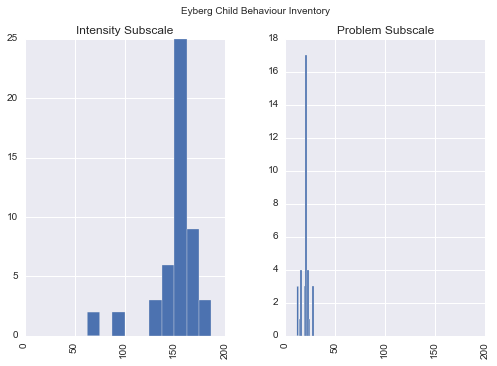

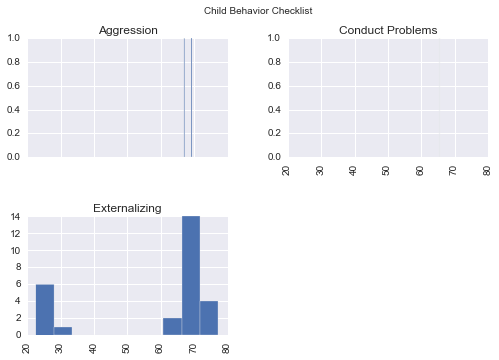

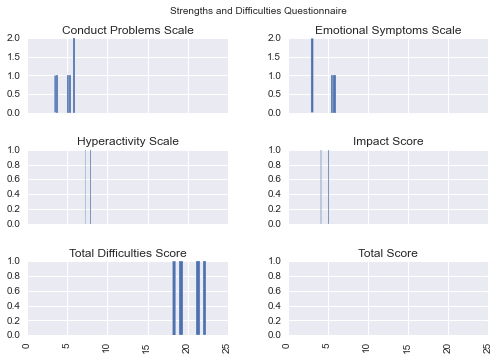

In [31]:
for instrument in ('Eyberg Child Behaviour Inventory', 
                   'Child Behavior Checklist', 
                   'Strengths and Difficulties Questionnaire'):
    eot_subset[eot_subset.instrument==instrument]['baseline_mean'].hist(by=eot_subset['subtype'], 
                                                                              sharex=True)
    plt.suptitle(instrument);

In [32]:
eot_subset.instrument.value_counts()

Eyberg Child Behaviour Inventory            86
Child Behavior Checklist                    31
Strengths and Difficulties Questionnaire    20
dtype: int64

In [33]:
eot_subset[eot_subset.RefID==441]

,RefID,measure_instrument,instrument,subtype,units,intvn,child_component,parent_component,family_component,baseline_n,...,followup_sd,change_n,change_mean,change_sd,child_only,parent_only,multi_component,eot_diff_mean,eot_diff_sd,eot_diff_n
14,441,"Eyberg Child Behaviour Inventory, Intensity Su...",Eyberg Child Behaviour Inventory,Intensity Subscale,Scale,iypt,0,1,0,32,...,NaN,NaN,NaN,NaN,0,1,0,-31.40,46.80,32
15,441,"Eyberg Child Behaviour Inventory, Problem Subs...",Eyberg Child Behaviour Inventory,Problem Subscale,Scale,iypt,0,1,0,24,...,NaN,NaN,NaN,NaN,0,1,0,-9.70,12.02,24
16,441,"Eyberg Child Behaviour Inventory, Intensity Su...",Eyberg Child Behaviour Inventory,Intensity Subscale,Scale,wlc,0,0,0,20,...,NaN,NaN,NaN,NaN,0,0,0,-5.80,49.60,20
17,441,"Eyberg Child Behaviour Inventory, Problem Subs...",Eyberg Child Behaviour Inventory,Problem Subscale,Scale,wlc,0,0,0,17,...,NaN,NaN,NaN,NaN,0,0,0,-2.88,14.59,17


Several studies use multiple instruments and metrics within instruments

In [34]:
eot_subset.groupby(['RefID', 'instrument'])['subtype'].value_counts()

RefID  instrument                                                        
441    Eyberg Child Behaviour Inventory          Problem Subscale            2
                                                 Intensity Subscale          2
475    Eyberg Child Behaviour Inventory          Intensity Subscale          2
539    Child Behavior Checklist                  Aggression                  2
                                                 Externalizing               2
564    Eyberg Child Behaviour Inventory          Problem Subscale            2
                                                 Intensity Subscale          2
899    Child Behavior Checklist                  Externalizing               3
       Eyberg Child Behaviour Inventory          Problem Subscale            3
                                                 Intensity Subscale          3
993    Strengths and Difficulties Questionnaire  Hyperactivity Scale         2
                                                 Total Di

In [35]:
pd.crosstab(eot_subset.instrument, eot_subset.subtype)

subtype,Aggression,Conduct Problems,Conduct Problems Scale,Emotional Symptoms Scale,Externalizing,Hyperactivity Scale,Impact Score,Intensity Subscale,Problem Subscale,Total Difficulties Score,Total Score
instrument,,,,,,,,,,,
Child Behavior Checklist,2,2,0,0,27,0,0,0,0,0,0
Eyberg Child Behaviour Inventory,0,0,0,0,0,0,0,50,36,0,0
Strengths and Difficulties Questionnaire,0,0,6,4,0,2,2,0,0,4,2


In [36]:
x = eot_subset[eot_subset.instrument=='Eyberg Child Behaviour Inventory']
pd.crosstab(x.instrument, x.subtype)

subtype,Intensity Subscale,Problem Subscale
instrument,,
Eyberg Child Behaviour Inventory,50,36


In [37]:
x = eot_subset[eot_subset.instrument=='Child Behavior Checklist']
pd.crosstab(x.instrument, x.subtype)

subtype,Aggression,Conduct Problems,Externalizing
instrument,,,
Child Behavior Checklist,2,2,27


In [38]:
x = eot_subset[eot_subset.instrument=='Strengths and Difficulties Questionnaire']
pd.crosstab(x.instrument, x.subtype)

subtype,Conduct Problems Scale,Emotional Symptoms Scale,Hyperactivity Scale,Impact Score,Total Difficulties Score,Total Score
instrument,,,,,,
Strengths and Difficulties Questionnaire,6,4,2,2,4,2


Merge study variables and outcomes

In [39]:
merged_vars = study_vars.merge(eot_subset, left_index=True, right_on='RefID')
merged_vars.shape

(137, 36)

For now, restrict to the three most prevalent metrics.

In [40]:
merged_vars.measure_instrument.value_counts()

Eyberg Child Behaviour Inventory, Intensity Subscale            46
Eyberg Child Behaviour Inventory, Problem Subscale              36
Child Behavior Checklist, Externalizing (T Score)               20
Child Behavior Checklist, Externalizing                          7
Strengths and Difficulties Questionnaire- Conduct Problems Scale     6
Eyberg Child Behaviour Inventory, Intensity Subscale (T Score)     4
Strengths and Difficulties Questionnaire- Total Difficulties Score     4
Strengths and Difficulties Questionnaire- Emotional Symptoms Scale     4
Strengths and Difficulties Questionnaire- Hyperactivity Scale     2
Child Behavior Checklist, Aggression                             2
Strengths and Difficulties Questionnaire- Impact Score           2
Child Behavior Checklist, Conduct Problems (T Score)             2
Strengths and Difficulties Questionnaire- Total Score            2
dtype: int64

In [41]:
analysis_subset = merged_vars[merged_vars.measure_instrument.isin(merged_vars.measure_instrument.value_counts().index[:4])]
analysis_subset.groupby('measure_instrument')['baseline_mean'].max()

measure_instrument
Child Behavior Checklist, Externalizing                  30.90
Child Behavior Checklist, Externalizing (T Score)        77.10
Eyberg Child Behaviour Inventory, Intensity Subscale    186.44
Eyberg Child Behaviour Inventory, Problem Subscale       28.62
Name: baseline_mean, dtype: float64

measure_instrument
Child Behavior Checklist, Externalizing                 Axes(0.125,0.125;0.775x0.775)
Child Behavior Checklist, Externalizing (T Score)       Axes(0.125,0.125;0.775x0.775)
Eyberg Child Behaviour Inventory, Intensity Subscale    Axes(0.125,0.125;0.775x0.775)
Eyberg Child Behaviour Inventory, Problem Subscale      Axes(0.125,0.125;0.775x0.775)
Name: baseline_mean, dtype: object

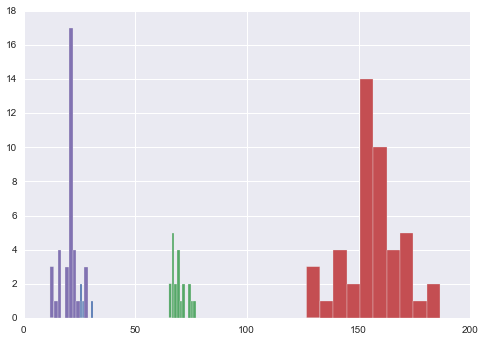

In [42]:
analysis_subset.groupby('measure_instrument').baseline_mean.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11020fc50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10fd9c0f0>]], dtype=object)

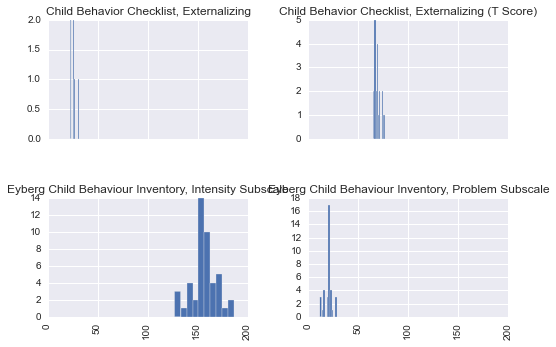

In [43]:
analysis_subset['baseline_mean'].hist(by=analysis_subset['measure_instrument'],sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f70ed30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10fe8cef0>]], dtype=object)

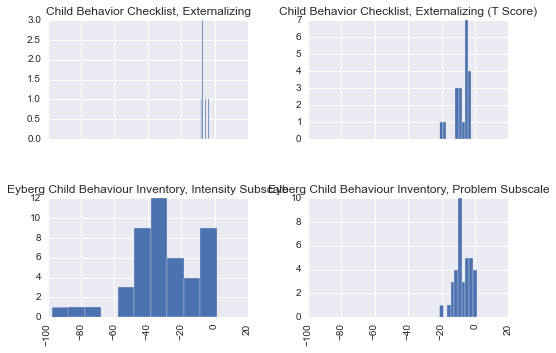

In [44]:
analysis_subset['eot_diff_mean'].hist(by=analysis_subset['measure_instrument'],sharex=True)

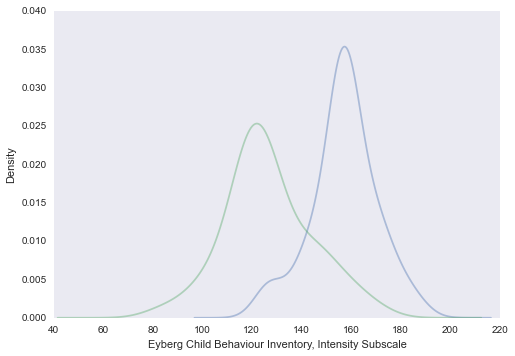

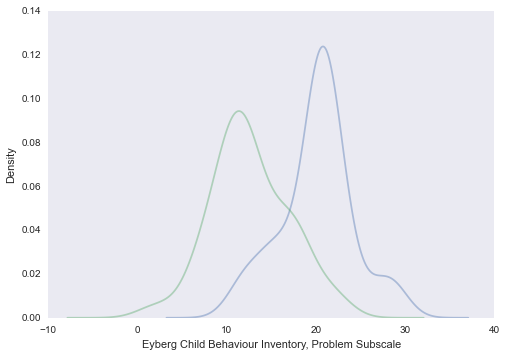

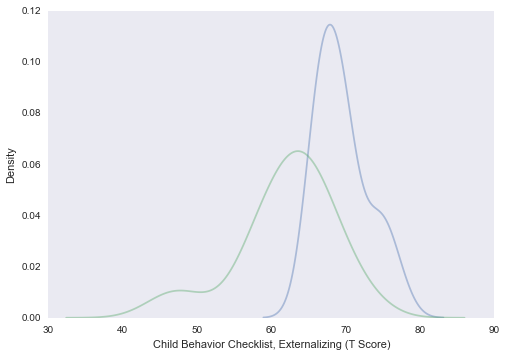

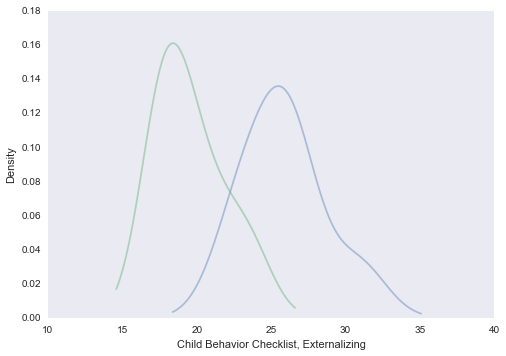

In [45]:
for x in analysis_subset.measure_instrument.unique():
    plt.figure()
    analysis_subset[analysis_subset.measure_instrument==x].baseline_mean.plot(kind='kde', alpha=0.4, grid=False)
    analysis_subset[analysis_subset.measure_instrument==x].end_treat_mean.plot(kind='kde', alpha=0.4, grid=False)
    plt.gca().set_xlabel(x)

## Meta-analysis

Number of studies in analysis subset

In [46]:
unique_studies = analysis_subset.RefID.unique().tolist()
len(unique_studies)

26

In [47]:
analysis_subset.RefID.unique()

array([ 441,  539,  564,  899, 1236, 1245, 1511, 1585, 1875, 1951, 2092,
       2117, 2219, 2239, 3211, 3225, 3397, 3399, 3495, 3687, 3716, 3766,
       3915, 3960, 7109, 7723])

We are restricting the analysis to the 4 most prevalent measure instruments in the database.

In [47]:
unique_measures = analysis_subset.measure_instrument.unique().tolist()
k = len(unique_measures)
unique_measures

['Eyberg Child Behaviour Inventory, Intensity Subscale',
 'Eyberg Child Behaviour Inventory, Problem Subscale',
 'Child Behavior Checklist, Externalizing (T Score)',
 'Child Behavior Checklist, Externalizing']

Three intervention components were coded:

* `child_component`
* `parent_component`
* `multi_component`

In [48]:
analysis_subset[['child_only', 'parent_only', 'multi_component']].sum(0)

child_only          6
parent_only        33
multi_component    27
dtype: int64

In [49]:
p_male, age_cat, intvn = analysis_subset[['p_male', 'age_cat', 'intvn']].values.T
child_only, parent_only, multi_component = analysis_subset[['child_only', 'parent_only', 
                                                                       'multi_component']].values.T

change_n, change_mean, change_sd = analysis_subset[['eot_diff_n', 'eot_diff_mean', 'eot_diff_sd']].values.T

In [50]:
school = (analysis_subset.age_cat.values==0).astype(int)
pre_k = (analysis_subset.age_cat.values==1).astype(int)
teen = (analysis_subset.age_cat.values==2).astype(int)

The response variable is a multivariate normal of dimension k=4, for each of the measure instruments.

$$\left({
\begin{array}{c}
  {m_1}\\
  {m_2}\\
  {m_3}\\
  {m_4}
\end{array}
}\right)_i \sim\text{MVN}(\mathbf{\mu},\Sigma)$$

Means for each study are a draw from a multivariate normal.

In [51]:
wishart = True

mu = pm.Normal('mu', 0, 0.001, value=[0]*k)

if wishart:
    T = pm.Wishart('T', k, np.eye(k), value=np.eye(k))
    
    m = [pm.MvNormal('m_{}'.format(i), mu, T, value=[0]*k) for i in range(len(unique_studies))]
else:
    sigmas = pm.Uniform('sigmas', 0, 100, value=[10]*k)
    rhos = pm.Uniform('rhos', -1, 1, value=[0]*int(comb(k, 2)))

    Sigma = pm.Lambda('Sigma', lambda s=sigmas, r=rhos: np.array([[s[0]**2, s[0]*s[1]*r[0], s[0]*s[2]*r[1], s[0]*s[3]*r[2]],
                                                         [s[0]*s[1]*r[0], s[1]**2, s[1]*s[2]*r[3], s[1]*s[3]*r[4]],
                                                         [s[0]*s[2]*r[1], s[1]*s[2]*r[3], s[2]**2, s[2]*s[3]*r[5]],
                                                         [s[0]*s[3]*r[2], s[1]*s[3]*r[4], s[2]*s[3]*r[5], s[3]**2]]))
    
    m = [pm.MvNormalCov('m_{}'.format(i), mu, Sigma, value=[0]*k) for i in range(len(unique_studies))]



Unique intervention labels for each component; we will use these for component random effects.

In [52]:
unique_child_intvn = np.unique(intvn[child_only.astype(bool)]).tolist()
unique_parent_intvn = np.unique(intvn[parent_only.astype(bool)]).tolist()
unique_multi_intvn = np.unique(intvn[multi_component.astype(bool)]).tolist()

In [53]:
# Indices to random effect labels
child_component_index = [unique_child_intvn.index(x) for x in intvn[child_only.astype(bool)]]
parent_component_index = [unique_parent_intvn.index(x) for x in intvn[parent_only.astype(bool)]]
multi_component_index = [unique_multi_intvn.index(x) for x in intvn[multi_component.astype(bool)]]

Treatment component random effects

$$X_i = \left[{
\begin{array}{c}
  {x_c}\\
  {x_p}\\
  {x_f}\\
\end{array}
}\right]_i$$

$$\begin{aligned}
\beta_j^{(c)} &\sim N(\mu_{\beta}^{(c)},\tau_{\beta}^{(c)}) \\
\beta_j^{(p)} &\sim N(\mu_{\beta}^{(p)},\tau_{\beta}^{(p)}) \\
\beta_j^{(f)} &\sim N(\mu_{\beta}^{(f)},\tau_{\beta}^{(f)})
\end{aligned}$$

In [54]:
mu_beta = pm.Normal('mu_beta', 0, 0.001, value=[0]*3)
# sig_beta = pm.Uniform('sig_beta', 0, 100, value=1)
# tau_beta = sig_beta ** -2
tau_beta = pm.Gamma('tau_beta', 1, 0.1, value=1)

beta_c = pm.Normal('beta_c', mu_beta[0], tau_beta, value=[0]*len(unique_child_intvn))
beta_p = pm.Normal('beta_p', mu_beta[1], tau_beta, value=[0]*len(unique_parent_intvn))
beta_m = pm.Normal('beta_m', mu_beta[2], tau_beta, value=[0]*len(unique_multi_intvn))

b_c = pm.Lambda('b_c', lambda b=beta_c: 
             np.array([b[unique_child_intvn.index(x)] if child_only[i] else 0 for i,x in enumerate(intvn)]))
b_p = pm.Lambda('b_p', lambda b=beta_p: 
             np.array([b[unique_parent_intvn.index(x)] if parent_only[i] else 0 for i,x in enumerate(intvn)]))
b_m = pm.Lambda('b_m', lambda b=beta_m: 
             np.array([b[unique_multi_intvn.index(x)] if multi_component[i] else 0 for i,x in enumerate(intvn)]))


In [55]:
best = pm.Lambda('best', lambda b=mu_beta:  (b==b.min()).astype(int))

Interaction of parent and multi-component with pre-k children.

In [56]:
interaction = False

if interaction:
    beta_pk_p = pm.Normal('beta_pk_p', 0, 1e-5, value=0)
    beta_pk_m = pm.Normal('beta_pk_m', 0, 1e-5, value=0)
    b_pk_p = pm.Lambda('b_pk_p', lambda b=beta_pk_p: b * parent_only * pre_k)
    b_pk_m = pm.Lambda('b_pk_m', lambda b=beta_pk_m: b * multi_component * pre_k)

In [57]:
betas = b_c + b_p + b_m 

if interaction:
    betas = betas + b_pk_p + b_pk_m

Covariate effects of age and percent female.

$$\alpha \sim N(0, 1e5)$$

In [58]:
alpha_age = pm.Normal('alpha_age', 0, 1e-5, value=[1,2])

Unique study ID (`RefID`) and measure ID (`measure_instrument`) values.

In [59]:
study_id = [unique_studies.index(x) for x in analysis_subset.RefID]
measure_id = [unique_measures.index(x) for x in analysis_subset.measure_instrument]

Calculate expected response (treatment difference) as a function of treatment and covariates.

$$\theta_i = m_{j[i]k} + X_i \beta + \alpha x_{age}$$ 

In [60]:
baseline_sd = analysis_subset.baseline_sd.values

@pm.deterministic
def theta(m=m, betas=betas, alpha_age=alpha_age):  

    mi = [m[i][j] for i,j in zip(study_id, measure_id)]
    
    age_effect = np.array([alpha_age[a-1] if a else 0 for a in age_cat])
    
    return(mi + baseline_sd*(betas + age_effect))

Expected treatment effect for pre-K undergoing multi-component intervention, measused by Eyberg Child Behaviour Inventory, Intensity Subscale

In [61]:
baseline = pm.MvNormalCov('baseline', mu, T, value=[0]*k)

In [90]:
baseline.value

array([-11.06741267,  -5.70084153,   0.69459544,  -0.22081427])

In [91]:
prek_intensity_pred.value

array([-28.04477227, -36.69907645, -38.89229893])

In [62]:
ecbi_intensity_sd = baseline_sd[np.array(measure_id)==0].mean()

prek_intensity_pred = pm.Lambda('prek_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*(b + a[0]) )
school_intensity_pred = pm.Lambda('school_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*b )
teen_intensity_pred = pm.Lambda('teen_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*(b + a[1]) )

intensity_diff = pm.Lambda('intensity_diff', 
                           lambda base=baseline, prek=prek_intensity_pred, school=school_intensity_pred, 
                           teen=teen_intensity_pred: np.array([prek, school, teen])-base[0])
                            

ecbi_problem_sd = baseline_sd[np.array(measure_id)==1].mean()

prek_problem_pred = pm.Lambda('prek_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*(b + a[0]) )
school_problem_pred = pm.Lambda('school_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*b )
teen_problem_pred = pm.Lambda('teen_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*(b + a[1]) )

problem_diff = pm.Lambda('problem_diff', 
                           lambda base=baseline, prek=prek_problem_pred, school=school_problem_pred, 
                           teen=teen_problem_pred: np.array([prek, school, teen])-base[1])

cbct_sd = baseline_sd[np.array(measure_id)==2].mean()

prek_tscore_pred = pm.Lambda('prek_tscore_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[2] + cbct_sd*(b + a[0]) )
school_tscore_pred = pm.Lambda('school_tscore_pred', 
                            lambda mu=baseline, b=mu_beta: mu[2] + cbct_sd*b )
teen_tscore_pred = pm.Lambda('teen_tscore_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[2] + cbct_sd*(b + a[1]) )

tscore_diff = pm.Lambda('tscore_diff', 
                           lambda base=baseline, prek=prek_tscore_pred, school=school_tscore_pred, 
                           teen=teen_tscore_pred: np.array([prek, school, teen])-base[2])

cbcr_sd = baseline_sd[np.array(measure_id)==3].mean()

prek_raw_pred = pm.Lambda('prek_raw_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[3] + cbcr_sd*(b + a[0]) )
school_raw_pred = pm.Lambda('school_raw_pred', 
                            lambda mu=baseline, b=mu_beta: mu[3] + cbcr_sd*b )
teen_raw_pred = pm.Lambda('teen_raw_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[3] + cbcr_sd*(b + a[1]) )

raw_diff = pm.Lambda('raw_diff', 
                           lambda base=baseline, prek=prek_raw_pred, school=school_raw_pred, 
                           teen=teen_raw_pred: np.array([prek, school, teen])-base[3])

In [88]:
prek_raw_pred.value

array([ -7.03404672, -10.50713013, -11.38729848])

Finally, the likelihood is just a normal distribution, with the observed standard error of the treatment effect as the standard deviation of the estimates.

$$d_i \sim N(\theta_i, \hat{\sigma}^2)$$

In [63]:
change_se = change_sd/np.sqrt(change_n)

In [64]:
d = pm.Normal('d', theta, change_se**-2, observed=True, value=change_mean)

Posterior predictive samples

In [65]:
d_sim = pm.Normal('d_sim', theta, change_se**-2, size=len(change_mean))

In [66]:
M = pm.MCMC(locals())
M.use_step_method(pm.AdaptiveMetropolis, [mu])
M.use_step_method(pm.AdaptiveMetropolis, m)
M.use_step_method(pm.AdaptiveMetropolis, mu_beta)
M.use_step_method(pm.AdaptiveMetropolis, [beta_c, beta_p, beta_m])

In [67]:
M.sample(200000, 190000)

 [-----------------100%-----------------] 200000 of 200000 complete in 613.1 sec

Summary of estimates of intervention components

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


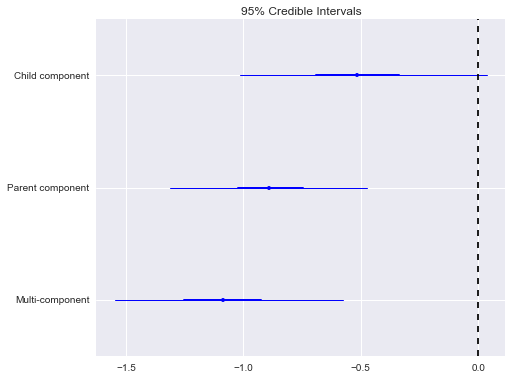

In [68]:
pm.Matplot.summary_plot([mu_beta], custom_labels=['Child component', 'Parent component', 
                                                              'Multi-component'])

In [69]:
mu_beta.summary()


mu_beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.512           0.273            0.014            [-1.016  0.037]
	-0.885           0.212            0.011            [-1.315 -0.475]
	-1.093           0.247            0.014            [-1.548 -0.578]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-1.056           -0.691          -0.514         -0.335        0.014
	-1.308           -1.025          -0.889         -0.746        -0.452
	-1.596           -1.254          -1.089         -0.927        -0.6
	


In [70]:
best.summary()


best:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.03             0.17             0.005                  [ 0.  0.]
	0.235            0.424            0.02                   [ 0.  1.]
	0.735            0.441            0.02                   [ 0.  1.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.0             0.0            0.0           1.0
	0.0              0.0             0.0            0.0           1.0
	0.0              0.0             1.0            1.0           1.0
	


Plotting mu_beta_0
Plotting mu_beta_1
Plotting mu_beta_2


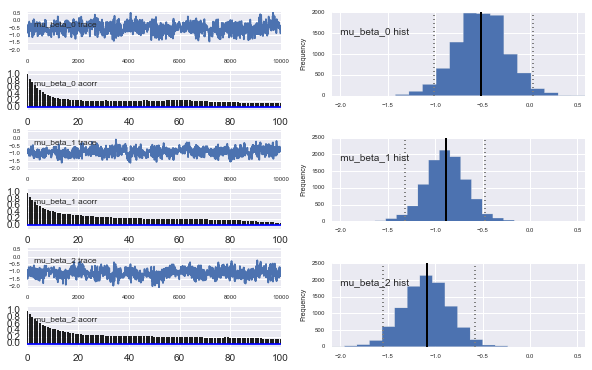

In [71]:
pm.Matplot.plot(mu_beta)

In [72]:
if interaction:
    pm.Matplot.summary_plot([beta_pk_m, beta_pk_p])

Difference means by measure instrument.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


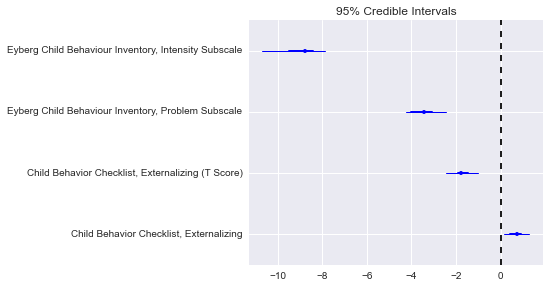

In [73]:
plt.figure(figsize=(24,4))
pm.Matplot.summary_plot([mu], custom_labels=unique_measures)

Plotting mu_0
Plotting mu_1
Plotting mu_2
Plotting mu_3


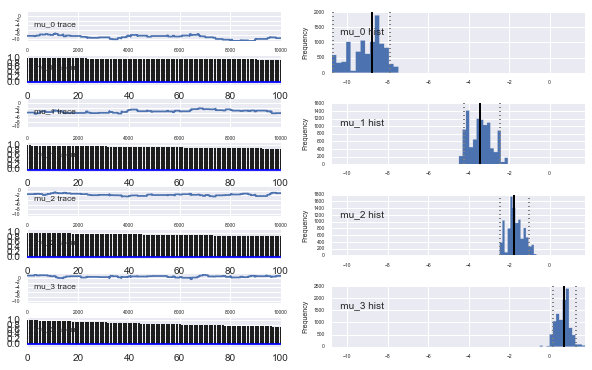

In [74]:
pm.Matplot.plot(mu)

In [75]:
if not wishart:
    plt.figure(figsize=(24,4))
    pm.Matplot.summary_plot([sigmas], custom_labels=unique_measures)

In [76]:
if not wishart:
    pm.Matplot.summary_plot([rhos], custom_labels=['rho12', 'rho13', 'rho14', 'rho23', 'rho24', 'rho34'])

Age effects for pre-k (top) and teen (bottom) groups, relative to pre-teen.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


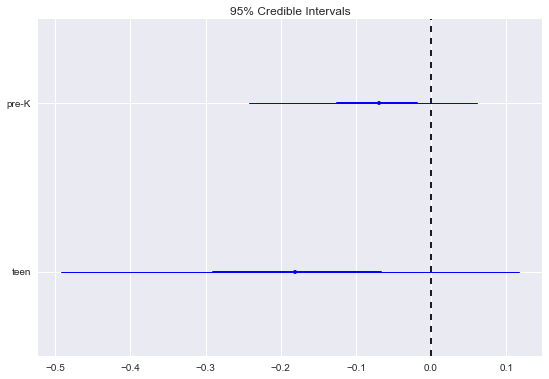

In [77]:
pm.Matplot.summary_plot([alpha_age], custom_labels=['pre-K', 'teen'])

In [78]:
alpha_age.summary()


alpha_age:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.072           0.08             0.006            [-0.242  0.062]
	-0.177           0.161            0.013            [-0.493  0.118]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.232           -0.125          -0.07          -0.018        0.078
	-0.481           -0.29           -0.181         -0.067        0.131
	


Plotting alpha_age_0
Plotting alpha_age_1


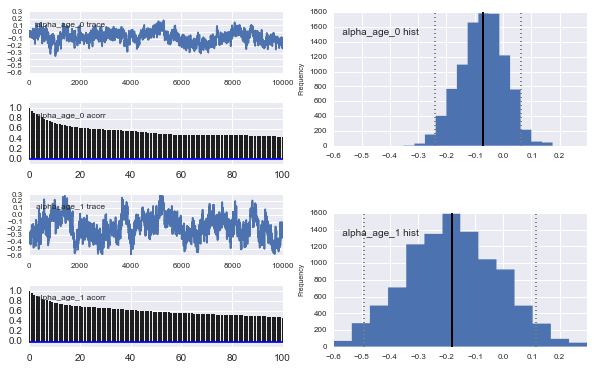

In [79]:
pm.Matplot.plot(alpha_age)

## Outcome Plots

In [80]:
traces = [[school_intensity_pred, prek_intensity_pred, teen_intensity_pred],
          [school_problem_pred, prek_problem_pred, teen_problem_pred],
          [school_tscore_pred, prek_tscore_pred, teen_tscore_pred],
          [school_raw_pred, prek_raw_pred, teen_raw_pred]]

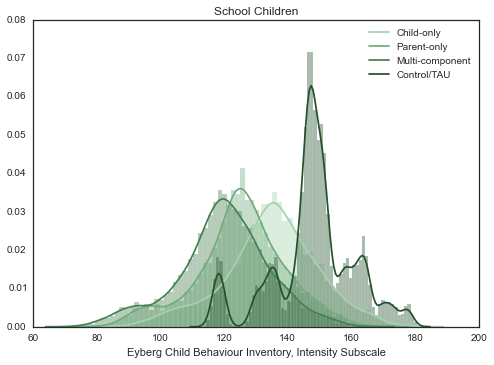

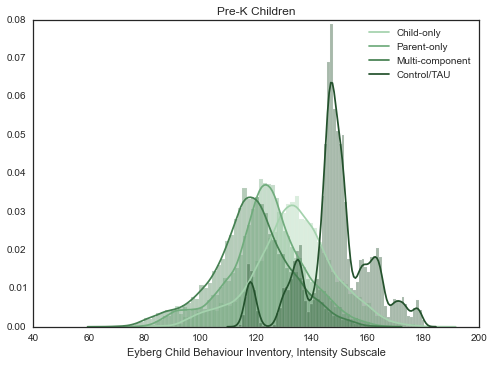

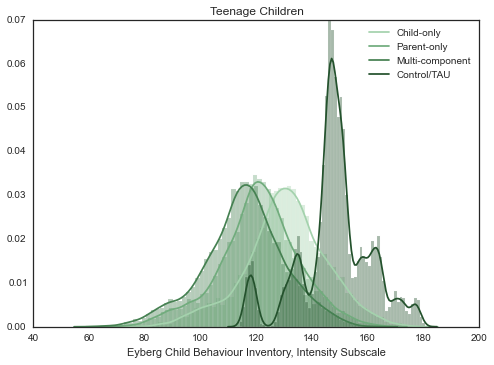

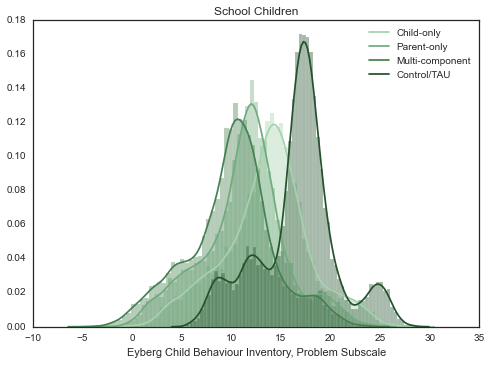

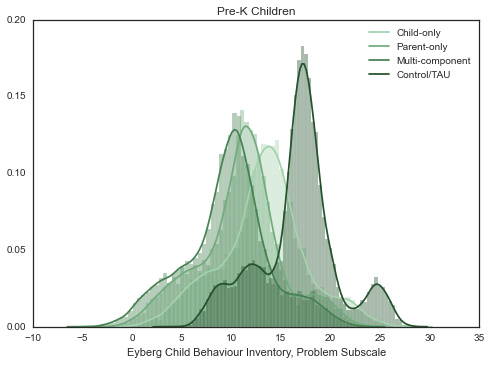

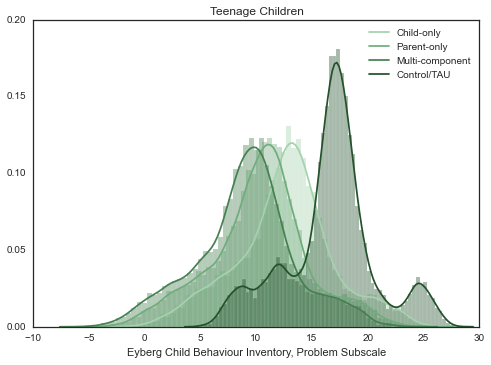

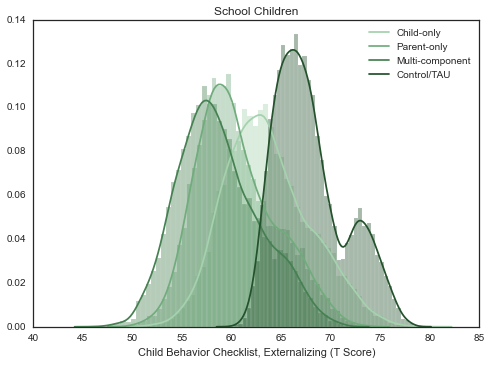

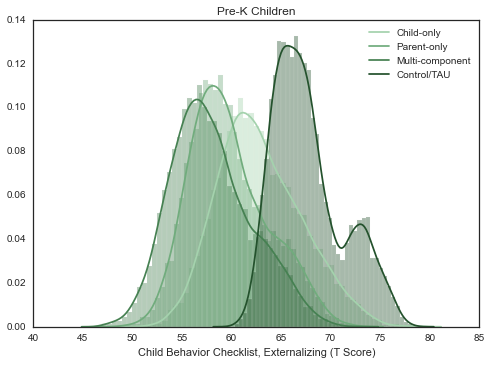

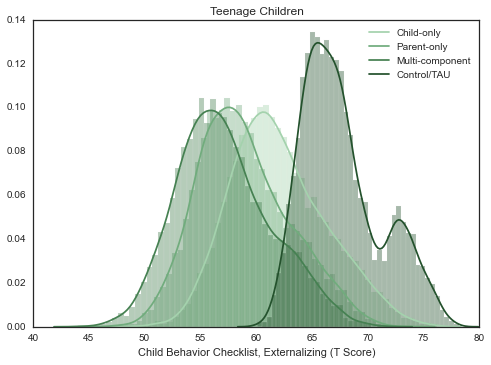

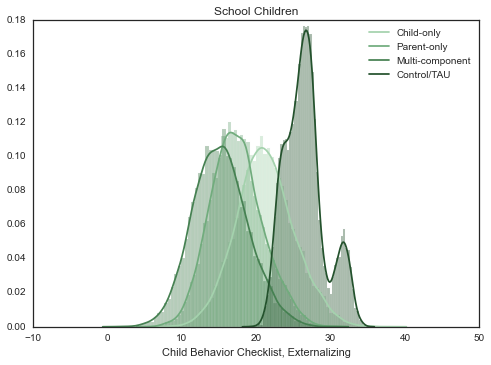

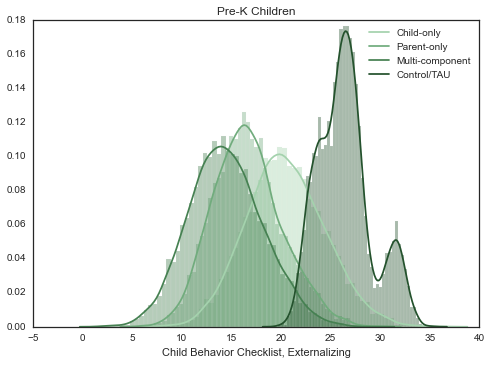

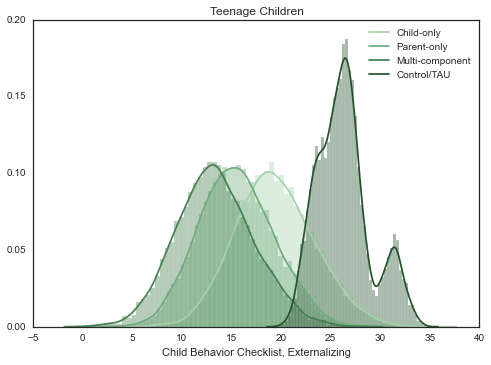

In [81]:
sb.set(style="white", palette="hot")
sb.despine(left=True)

#colors = '#fef0d9','#fdcc8a','#fc8d59','#d7301f'
colors = sb.cubehelix_palette(4, start=2, rot=0, dark=.25, light=.75, reverse=False)

titles = ['School Children', 'Pre-K Children', 'Teenage Children']

for i,measure in enumerate(unique_measures):
    
    measure_traces = traces[i]
    
    for j, trace in enumerate(measure_traces):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        plt.figure()
        g = sb.distplot(x + c1, color=colors[0])
        sb.distplot(x + p1, color=colors[1])
        sb.distplot(x + m1, color=colors[2])
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        sb.distplot(x + baseline.trace()[:, i] + age_effect, color=colors[3]);
        g.set_title(titles[j])

        g.legend(g.lines, ['Child-only', 'Parent-only', 'Multi-component', 'Control/TAU'])

        g.set_xlabel(measure)

Generate threshold proportions

In [112]:
thresholds = [127, # ECBI, intensity
              11,  # ECBI, problem
              60]  # CBC t-score

age_labels = ['school', 'pre-k', 'teen']

estimates = []

for i,measure in enumerate(unique_measures[:-1]):
    
    measure_traces = traces[i]
    cutoff = thresholds[i]
    
    for j, trace in enumerate(measure_traces):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        child_only = ((x + c1) > cutoff).mean().round(2)
        parent_only = ((x + p1) > cutoff).mean().round(2)
        multi_component = ((x + m1) > cutoff).mean().round(2)
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        control = ((x + baseline.trace()[:, i] + age_effect) > cutoff).mean().round(2)
        
        print('\n{0}, {1}'.format(measure, age_labels[j]))
        print('Child-only: {0}\nParent-only: {1}\nMulti-component: {2}\nControl/TAU: {3}'.format(child_only, 
                                                                                                 parent_only,
                                                                                                 multi_component,
                                                                                                 control))
        
        estimates.append((measure, age_labels[j], child_only, parent_only, multi_component, control))
        


Eyberg Child Behaviour Inventory, Intensity Subscale, school
Child-only: 0.74
Parent-only: 0.44
Multi-component: 0.29
Control/TAU: 0.93

Eyberg Child Behaviour Inventory, Intensity Subscale, pre-k
Child-only: 0.69
Parent-only: 0.38
Multi-component: 0.24
Control/TAU: 0.93

Eyberg Child Behaviour Inventory, Intensity Subscale, teen
Child-only: 0.62
Parent-only: 0.32
Multi-component: 0.2
Control/TAU: 0.93

Eyberg Child Behaviour Inventory, Problem Subscale, school
Child-only: 0.76
Parent-only: 0.58
Multi-component: 0.42
Control/TAU: 0.89

Eyberg Child Behaviour Inventory, Problem Subscale, pre-k
Child-only: 0.74
Parent-only: 0.53
Multi-component: 0.36
Control/TAU: 0.89

Eyberg Child Behaviour Inventory, Problem Subscale, teen
Child-only: 0.67
Parent-only: 0.43
Multi-component: 0.29
Control/TAU: 0.88

Child Behavior Checklist, Externalizing (T Score), school
Child-only: 0.79
Parent-only: 0.49
Multi-component: 0.34
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), pre-k


In [115]:
pd.DataFrame(estimates, columns=['Instrument', 'Age group', 'Child-only', 
                                 'Parent-only', 'Multi-component', 'TAU/Control']).to_csv('outcome_proportions.csv')

Summary statistics for TAU/control

In [82]:
baseline.summary()


baseline:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-9.01            1.282            0.078          [-11.54   -6.534]
	-3.416           1.14             0.056            [-5.666 -1.2  ]
	-1.684           1.088            0.041            [-3.898  0.383]
	0.668            1.054            0.033            [-1.314  2.805]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-11.62           -9.841          -8.983         -8.12         -6.596
	-5.644           -4.2            -3.423         -2.651        -1.159
	-3.804           -2.409          -1.685         -0.95         0.484
	-1.415           -0.038          0.681          1.378         2.73
	


Summary statistics for intensity subscale

In [83]:
prek_intensity_pred.summary()
school_intensity_pred.summary()
teen_intensity_pred.summary()


prek_intensity_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-24.087          7.373            0.397          [-38.518 -10.046]
	-33.707          5.434            0.264          [-44.213 -22.895]
	-39.065          6.373            0.332          [-51.605 -26.443]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-38.422          -28.983         -24.24         -19.185       -9.832
	-44.13           -37.297         -33.877        -30.089       -22.764
	-51.605          -43.294         -38.948        -34.872       -26.443
	

school_intensity_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-22.228          7.229            0.389          [-36.756  -8.196]
	-31.849          5.548    

Summary statistics for problem subscale

In [84]:
prek_problem_pred.summary()
school_problem_pred.summary()
teen_problem_pred.summary()


prek_problem_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-6.978           1.977            0.088          [-10.883  -3.123]
	-9.251           1.674            0.077          [-12.385  -5.862]
	-10.516          1.843            0.089          [-14.253  -7.029]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-10.887          -8.308          -6.977         -5.664        -3.126
	-12.518          -10.416         -9.254         -8.112        -5.976
	-14.147          -11.716         -10.514        -9.279        -6.897
	

school_problem_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-6.539           1.976            0.093          [-10.567  -2.79 ]
	-8.811           1.728          

Summary statistics for t scores

In [85]:
prek_tscore_pred.summary()
school_tscore_pred.summary()
teen_tscore_pred.summary()


prek_tscore_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-6.606           2.631            0.137          [-11.734  -1.491]
	-9.746           2.041            0.092          [-13.815  -5.696]
	-11.495          2.346            0.119          [-16.31   -7.034]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-11.707          -8.426          -6.63          -4.815        -1.441
	-13.794          -11.113         -9.751         -8.408        -5.66
	-16.219          -13.044         -11.475        -9.941        -6.932
	

school_tscore_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-5.999           2.581            0.133          [-11.196  -1.046]
	-9.139           2.065            0

Summary statistics for raw scores

In [86]:
prek_raw_pred.summary()
school_raw_pred.summary()
teen_raw_pred.summary()


prek_raw_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-5.382           3.07             0.155          [-11.237   0.697]
	-9.243           2.404            0.115          [-13.968  -4.468]
	-11.393          2.728            0.133          [-16.791  -6.023]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-11.329          -7.435          -5.403         -3.337        0.634
	-14.038          -10.82          -9.245         -7.652        -4.519
	-16.823          -13.182         -11.345        -9.571        -6.039
	

school_raw_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-4.636           2.996            0.148          [-10.491   1.312]
	-8.497           2.423            0.121  

#### Summary statistics for differences.

Each summary corresponds to teh differences between baseline and age x component categories for each outcome. The order is:

- child-only, pre-k
- child-only, school
- child-only, teen
- parent-only, pre-k
- parent-only, school
- parent-only, teen
- multi, pre-k
- multi, school
- multi, teen


In [92]:
import IPython

In [87]:
intensity_diff.summary()
problem_diff.summary()
tscore_diff.summary()
raw_diff.summary()


intensity_diff:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-15.077          7.244            0.384          [-29.624  -1.801]
	-24.697          5.411            0.279          [-35.928 -14.465]
	-30.055          6.309            0.331          [-43.126 -18.353]
	-13.218          7.052            0.369          [-26.209   0.942]
	-22.838          5.468            0.296          [-33.908 -12.256]
	-28.196          6.377            0.371          [-39.935 -14.902]
	-17.796          7.324            0.357          [-32.289  -2.936]
	-27.417          6.6              0.415          [-41.248 -15.337]
	-32.774          7.033            0.416          [-46.001 -18.668]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-29.161          -19.84          -15.25         -10.301       -1.22